**TASK 3: Customer Segmentation / Clustering**

In [30]:
#importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import logging
from datetime import datetime
import warnings
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from datetime import datetime

warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CustomerSegmentation:
    def __init__(self, customers_path: str, transactions_path: str):
        """Initializes with the paths to customer and transaction data."""
        self.customers_path = customers_path
        self.transactions_path = transactions_path
        self.customer_profile = None
        self.scaled_data = None
        self.best_k = None
        self.kmeans_model = None
        self.gmm_model = None
        self.metrics_report = {}



    def load_and_preprocess_data(self) -> None:
        """Loads and preprocesses the customer and transaction data."""
        logger.info("Loading and preprocessing data...")

        try:
            # Load data
            customers_df = pd.read_csv(self.customers_path)
            transactions_df = pd.read_csv(self.transactions_path)

            # Merge data
            df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')
            df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

            # Feature Engineering
            customer_metrics = self._calculate_customer_metrics(df)

            # Standardizing features
            scaler = StandardScaler()
            self.scaled_data = scaler.fit_transform(customer_metrics)
            self.customer_profile = customer_metrics

            logger.info(f"Processed data for {len(customer_metrics)} customers")
        except Exception as e:
            logger.error(f"Error in data preprocessing: {str(e)}")
            raise

    def _calculate_customer_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
      logger.info("Calculating customer metrics...")

      try:
          metrics = {
              'total_spending': df.groupby('CustomerID')['TotalValue'].sum(),
              'transaction_frequency': df.groupby('CustomerID')['TransactionID'].count(),
              'recency': (df['TransactionDate'].max() - df.groupby('CustomerID')['TransactionDate'].max()).dt.total_seconds() / (24 * 60 * 60),
              'avg_transaction_value': df.groupby('CustomerID')['TotalValue'].mean(),
              'avg_purchase_interval': df.groupby('CustomerID')['TransactionDate'].agg(
                  lambda x: np.diff(sorted(x.dt.date)).mean().days if len(x) > 1 else 0)
          }
          metrics['clv'] = metrics['total_spending'] * metrics['transaction_frequency']  # Customer Lifetime Value

          # Convert metrics to DataFrame
          metrics_df = pd.DataFrame(metrics).fillna(0)
          return metrics_df

      except Exception as e:
          logger.error(f"Error in calculating customer metrics: {str(e)}")
          raise


    def find_optimal_clusters(self, max_clusters: int = 10) -> int:
        """Finds the optimal number of clusters using various methods."""
        logger.info("Finding optimal number of clusters...")

        try:
            scores = {'inertia': [], 'silhouette': [], 'calinski': []}

            for k in range(2, max_clusters + 1):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(self.scaled_data)

                scores['inertia'].append(kmeans.inertia_)
                scores['silhouette'].append(silhouette_score(self.scaled_data, labels))
                scores['calinski'].append(calinski_harabasz_score(self.scaled_data, labels))

            self._plot_cluster_evaluation(scores)
            self.best_k = self._elbow_point(range(2, max_clusters + 1), scores['inertia'])
            logger.info(f"Optimal number of clusters: {self.best_k}")

            return self.best_k
        except Exception as e:
            logger.error(f"Error in finding optimal clusters: {str(e)}")
            raise

    def perform_clustering(self) -> None:
      """Performs clustering using both KMeans and GMM."""
      logger.info("Performing clustering...")

      try:
          if self.best_k is None:
              self.find_optimal_clusters()

          # KMeans clustering
          self.kmeans_model = KMeans(n_clusters=self.best_k, random_state=42, n_init=10)
          kmeans_labels = self.kmeans_model.fit_predict(self.scaled_data)

          # GMM clustering
          self.gmm_model = GaussianMixture(n_components=self.best_k, random_state=42)
          gmm_labels = self.gmm_model.fit_predict(self.scaled_data)

          # Save metrics for report
          self.metrics_report['kmeans'] = {
              'db_index': davies_bouldin_score(self.scaled_data, kmeans_labels),
              'silhouette': silhouette_score(self.scaled_data, kmeans_labels),
              'calinski': calinski_harabasz_score(self.scaled_data, kmeans_labels)
          }
          self.metrics_report['gmm'] = {
              'db_index': davies_bouldin_score(self.scaled_data, gmm_labels),
              'silhouette': silhouette_score(self.scaled_data, gmm_labels),
              'calinski': calinski_harabasz_score(self.scaled_data, gmm_labels)
          }

          # Save the DB Index, Silhouette Score, etc., as class attributes
          self.db_index = self.metrics_report['kmeans']['db_index']  # You can pick KMeans or GMM
          self.silhouette_score = self.metrics_report['kmeans']['silhouette']
          self.calinski_score = self.metrics_report['kmeans']['calinski']

          # Assign the labels to the class attributes
          self.labels = kmeans_labels  # Use KMeans labels or store both KMeans and GMM labels
          self.customer_profile['KMeans_Cluster'] = kmeans_labels
          self.customer_profile['GMM_Cluster'] = gmm_labels

          logger.info(f"Clustering performed with {self.best_k} clusters using KMeans and GMM.")

      except Exception as e:
          logger.error(f"Error in performing clustering: {str(e)}")
          raise

    def generate_report(self) -> None:
        """Generates a PDF report on clustering results."""
        logger.info("Generating PDF report...")

        try:
            # Get the timestamp for the report filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            report_file = f"Shrinath_Asati_Clustering_{timestamp}.pdf"

            # Create a canvas for the PDF
            c = canvas.Canvas(report_file, pagesize=letter)
            width, height = letter

            # Title of the report
            c.setFont("Helvetica-Bold", 16)
            c.drawString(200, height - 50, "Clustering Results Report")

            # Date and Time
            c.setFont("Helvetica", 12)
            c.drawString(40, height - 100, f"Generated on: {datetime.now()}")

            # Section 1: Number of clusters
            c.setFont("Helvetica-Bold", 12)
            c.drawString(40, height - 150, "Number of Clusters Formed:")
            c.setFont("Helvetica", 12)
            c.drawString(220, height - 150, f"{len(self.labels)}")

            # Section 2: DB Index
            c.setFont("Helvetica-Bold", 12)
            c.drawString(40, height - 200, "DB Index value:")
            c.setFont("Helvetica", 12)
            c.drawString(160, height - 200, f"{self.db_index:.3f}")

            # Section 3: Other Relevant Clustering Metrics
            c.setFont("Helvetica-Bold", 12)
            c.drawString(40, height - 250, "Other Relevant Clustering Metrics:")

            # KMeans Metrics
            c.setFont("Helvetica", 12)
            y_position = height - 270
            c.drawString(40, y_position, f"KMeans DB Index: {self.metrics_report['kmeans']['db_index']:.3f}")
            y_position -= 20
            c.drawString(40, y_position, f"KMeans Silhouette Score: {self.metrics_report['kmeans']['silhouette']:.3f}")
            y_position -= 20
            c.drawString(40, y_position, f"KMeans Calinski-Harabasz Score: {self.metrics_report['kmeans']['calinski']:.3f}")

            # GMM Metrics
            y_position -= 20
            c.drawString(40, y_position, f"GMM DB Index: {self.metrics_report['gmm']['db_index']:.3f}")
            y_position -= 20
            c.drawString(40, y_position, f"GMM Silhouette Score: {self.metrics_report['gmm']['silhouette']:.3f}")
            y_position -= 20
            c.drawString(40, y_position, f"GMM Calinski-Harabasz Score: {self.metrics_report['gmm']['calinski']:.3f}")

            # Save the PDF
            c.save()

            logger.info(f"PDF Report generated and saved to {report_file}.")

        except Exception as e:
            logger.error(f"Error in generating PDF report: {str(e)}")
            raise

    def save_results(self) -> None:
        """Saves the clustering results and customer profiles to a file."""
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_file = f"customer_segments_{timestamp}.csv"
            self.customer_profile.to_csv(output_file)
            logger.info(f"Results saved to {output_file}")
        except Exception as e:
            logger.error(f"Error in saving results: {str(e)}")
            raise

    def _elbow_point(self, k_values, inertias) -> int:
        """Identifies the elbow point in the inertia graph."""
        coords = np.column_stack((k_values, inertias))
        dists = np.zeros(len(k_values))

        for i in range(len(k_values)):
            p = coords[i]
            a = coords[0]
            b = coords[-1]
            dists[i] = np.abs(np.cross(b - a, p - a)) / np.linalg.norm(b - a)

        return k_values[np.argmax(dists)]

    def _plot_cluster_evaluation(self, scores: Dict) -> None:
        """Plots evaluation metrics for different clustering results."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        k_range = range(2, len(scores['inertia']) + 2)

        metrics = [
            ('Elbow Method', 'inertia', 'Inertia'),
            ('Silhouette Score', 'silhouette', 'Score'),
            ('Calinski-Harabasz Index', 'calinski', 'Score')
        ]

        for ax, (title, metric, ylabel) in zip(axes, metrics):
            ax.plot(k_range, scores[metric], marker='o')
            ax.set_title(title)
            ax.set_xlabel('Number of Clusters (k)')
            ax.set_ylabel(ylabel)

        plt.tight_layout()
        plt.show()


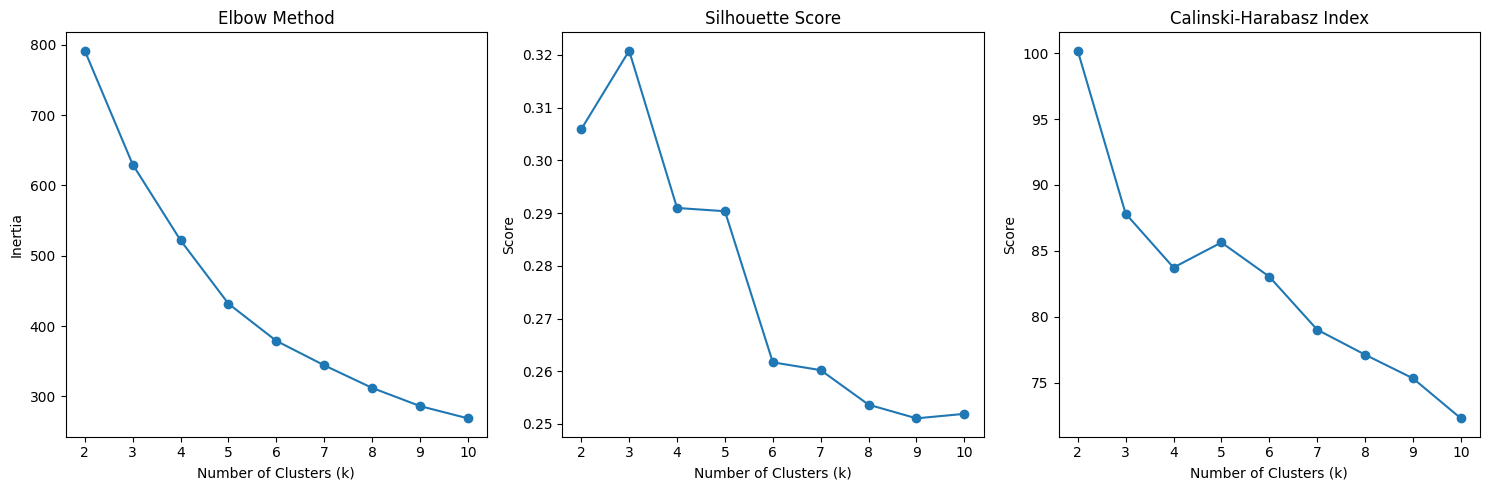

In [29]:
# execution part
segmentation = CustomerSegmentation('Customers.csv', 'Transactions.csv')
segmentation.load_and_preprocess_data()
segmentation.find_optimal_clusters()
segmentation.perform_clustering()
segmentation.generate_report()
segmentation.save_results()